# Apply Kalman Filter on Predictions of Amodal Expander

## Read the Prediction

In [121]:
import os
import cv2
import numpy as np
import json
from detectron2.data import detection_utils as utils
from IPython.display import display
from PIL import Image
import json
from tqdm import tqdm
from collections import defaultdict

prediction_file = '/data3/chengyeh/TAO-Amodal-experiments/GTR/AmodalExpander/TAO-Amodal/ModalMatch/PasteNOcclude/GTR_TAO_Amodal_Expander_PasteNOcclude/iter45000/inference_tao_amodal_val_v1/lvis_instances_results.json'

with open(prediction_file, 'r') as f:
    prediction = json.load(f)
    

In [122]:
# Preprocess the predictions so that we can get predictions from a certain track easily
vid_to_tracks = defaultdict(list)
vid_trackid_to_predictions = defaultdict(lambda : defaultdict(list))

for pred in prediction:
    vid_to_tracks[pred['video_id']].append(pred['track_id'])
    vid_trackid_to_predictions[pred['video_id']][pred['track_id']].append(pred)


In [123]:
# Load the annotation and get a sorted list of image ids for each video
annotation_file = '/home/chengyeh/TAO-Amodal-Root/TAO-GTR/datasets/tao/amodal_annotations/validation_with_freeform_amodal_boxes_Aug10_2022_oof_visibility_GTR_lvis_v1.json'

with open(annotation_file, 'r') as f:
    tao_amodal = json.load(f)

vid_to_sorted_img_ids = defaultdict(list)
vname_to_vid = dict()
for img in tao_amodal['images']:
    vid_to_sorted_img_ids[img['video_id']].append(img['id'])

for vid in vid_to_sorted_img_ids:
    vid_to_sorted_img_ids[vid] = list(sorted(vid_to_sorted_img_ids[vid]))

for video in tao_amodal['videos']:
    vname_to_vid[video['name']] = video['id']

img_id_to_img = {img['id']: img for img in tao_amodal['images']}

In [124]:
## Test each defaultdict
assert len(vid_to_tracks) == len(vid_trackid_to_predictions) == len(vid_to_sorted_img_ids)
print("{} Video ids: {}".format(len(vid_to_tracks), vid_to_tracks.keys()))
print("Randomly selected 10 Track ids in a video: {}".format(list(vid_trackid_to_predictions[4].keys())[:10]))
print("Randomly selected 10 Tracks in a video: \n{}".format(list(vid_trackid_to_predictions[4].values())[:10]))
print("Videos id {} with sorted image ids:\n{}".format(1344, vid_to_sorted_img_ids[1344]))

993 Video ids: dict_keys([4, 20, 22, 23, 24, 25, 26, 30, 31, 35, 36, 37, 39, 45, 49, 52, 54, 55, 58, 59, 62, 63, 65, 66, 68, 74, 75, 77, 78, 82, 84, 88, 90, 91, 98, 99, 102, 105, 108, 111, 112, 115, 116, 118, 120, 122, 123, 129, 130, 131, 137, 141, 148, 149, 150, 156, 162, 163, 165, 168, 169, 173, 174, 177, 179, 180, 190, 191, 194, 197, 202, 207, 209, 218, 222, 224, 228, 230, 234, 246, 247, 249, 256, 259, 262, 264, 267, 268, 269, 270, 271, 272, 273, 277, 278, 280, 286, 287, 288, 289, 290, 291, 292, 304, 308, 311, 312, 316, 321, 326, 329, 334, 336, 337, 338, 339, 342, 343, 344, 351, 353, 354, 355, 359, 364, 367, 368, 372, 375, 376, 380, 387, 392, 394, 401, 404, 406, 411, 413, 414, 416, 420, 422, 423, 424, 425, 426, 427, 428, 429, 430, 432, 435, 443, 444, 451, 453, 455, 457, 459, 460, 468, 474, 477, 478, 481, 484, 486, 489, 490, 492, 505, 507, 512, 518, 519, 520, 523, 530, 543, 544, 550, 554, 556, 563, 564, 565, 566, 567, 570, 573, 576, 580, 582, 584, 585, 587, 590, 591, 593, 596, 598, 6

## Create Kalman Filter Tracker

In [125]:
# from filterpy.kalman import KalmanFilter
# def convert_bbox_to_z(bbox):
#   """
#   Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
#     [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
#     the aspect ratio
#   """
#   w = bbox[2] - bbox[0]
#   h = bbox[3] - bbox[1]
#   x = bbox[0] + w/2.
#   y = bbox[1] + h/2.
#   s = w * h    #scale is just area
#   r = w / float(h)
#   return np.array([x, y, s, r]).reshape((4, 1))

# def convert_xy_to_wh(bbox):
#   return [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]

# def convert_wh_to_xy(bbox):
#   return [bbox[0], bbox[1], bbox[2] + bbox[0], bbox[3] + bbox[1]]

# def convert_x_to_bbox(x,score=None):
#   """
#   Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
#     [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
#   """
#   w = np.sqrt(x[2] * x[3])
#   h = x[2] / w
#   if(score==None):
#     return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
#   else:
#     return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))

# class KalmanBoxTracker(object):
#   """
#   This class represents the internal state of individual tracked objects observed as bbox.
#     bbox is formatted as [x1, y1, x2, y2]
#   """
#   count = 0
#   def __init__(self,bbox):
#     """
#     Initialises a tracker using initial bounding box.
#     """
#     #define constant velocity model
#     self.kf = KalmanFilter(dim_x=7, dim_z=4) 
#     self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
#     self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

#     self.kf.R[2:,2:] *= 10.
#     self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
#     self.kf.P *= 10.
#     self.kf.Q[-1,-1] *= 0.01
#     self.kf.Q[4:,4:] *= 0.01

#     self.kf.x[:4] = convert_bbox_to_z(bbox)
#     self.time_since_update = 0
#     self.id = KalmanBoxTracker.count
#     KalmanBoxTracker.count += 1
#     self.history = []
#     self.hits = 0
#     self.hit_streak = 0
#     self.age = 0

#   def update(self,bbox):
#     """
#     Updates the state vector with observed bbox.
#     """
#     self.time_since_update = 0
#     self.history = []
#     self.hits += 1
#     self.hit_streak += 1
#     self.kf.update(convert_bbox_to_z(bbox))

#   def predict(self):
#     """
#     Advances the state vector and returns the predicted bounding box estimate.
#     """
#     if((self.kf.x[6]+self.kf.x[2])<=0):
#       self.kf.x[6] *= 0.0
#     self.kf.predict()
#     self.age += 1
#     if(self.time_since_update>0):
#       self.hit_streak = 0
#     self.time_since_update += 1
#     self.history.append(convert_x_to_bbox(self.kf.x))
#     return self.history[-1]

#   def get_state(self):
#     """
#     Returns the current bounding box estimate.
#     """
#     return convert_x_to_bbox(self.kf.x)

In [126]:
from filterpy.kalman import KalmanFilter
def convert_bbox_to_z(bbox):
  """
  Takes a bounding box in the form [x1,y1,x2,y2,depth] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
    the aspect ratio
  """
  w = bbox[2] - bbox[0]
  h = bbox[3] - bbox[1]
  x = bbox[0] + w/2.
  y = bbox[1] + h/2.
  depth = bbox[4]
  s = w * h    #scale is just area
  r = w / float(h)
  return np.array([x, y, s, r, depth]).reshape((5, 1))

def convert_xy_to_wh(bbox):
  return [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]

def convert_wh_to_xy(bbox):
  return [bbox[0], bbox[1], bbox[2] + bbox[0], bbox[3] + bbox[1]]

def convert_x_to_bbox(x,score=None):
  """
  Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
    [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
  """
  w = np.sqrt(x[2] * x[3])
  h = x[2] / w
  if(score==None):
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2., x[4]]).reshape((1,5))
  else:
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2., x[4], score]).reshape((1,6))

class KalmanDepthBoxTracker(object):
  """
  This class represents the internal state of individual tracked objects observed as bbox.
    bbox is formatted as [x1, y1, x2, y2]
  """
  count = 0
  def __init__(self,bbox):
    """
    Initialises a tracker using initial bounding box.
    """
    #define constant velocity model
    # (x, y, s, r, d, vx, vy, vs, vd)
    self.kf = KalmanFilter(dim_x=9, dim_z=5) 
    self.kf.F = np.array([[1,0,0,0,0,1,0,0,0],  # x = x + vx
                          [0,1,0,0,0,0,1,0,0],
                          [0,0,1,0,0,0,0,0,0],  # Directly use the previous size
                          [0,0,0,1,0,0,0,0,0],  
                          [0,0,0,0,1,0,0,0,1],
                          [0,0,0,0,0,1,0,0,0],
                          [0,0,0,0,0,0,1,0,0],
                          [0,0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0,0],
                          [0,0,1,0,0,0,0,0,0],
                          [0,0,0,1,0,0,0,0,0],
                          [0,0,0,0,1,0,0,0,0]])

    # self.kf.R[2:,2:] *= 10. # A higher R value indicates less trust in the measurements
    self.kf.R[:, :] *= 0.01 # A higher R value indicates less trust in the measurements
    self.kf.P[5:,5:] *= 1000. #give high uncertainty to the unobservable initial velocities
    self.kf.P *= 10.
    self.kf.Q[-2,-2] *= 0.01
    self.kf.Q[5:,5:] *= 0.01

    self.kf.x[:5] = convert_bbox_to_z(bbox)
    self.time_since_update = 0
    self.id = KalmanDepthBoxTracker.count
    KalmanDepthBoxTracker.count += 1
    self.history = []
    self.hits = 0
    self.hit_streak = 0
    self.age = 0

  def update(self,bbox):
    """
    Updates the state vector with observed bbox.
    """
    self.time_since_update = 0
    self.history = []
    self.hits += 1
    self.hit_streak += 1
    self.kf.update(convert_bbox_to_z(bbox))

  def predict(self):
    """
    Advances the state vector and returns the predicted bounding box estimate.
    """
    if((self.kf.x[7]+self.kf.x[2])<=0):
      self.kf.x[7] *= 0.0
    self.kf.predict()
    self.age += 1
    if(self.time_since_update>0):
      self.hit_streak = 0
    self.time_since_update += 1
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    """
    Returns the current bounding box estimate.
    """
    return convert_x_to_bbox(self.kf.x)

## Load Depth Image

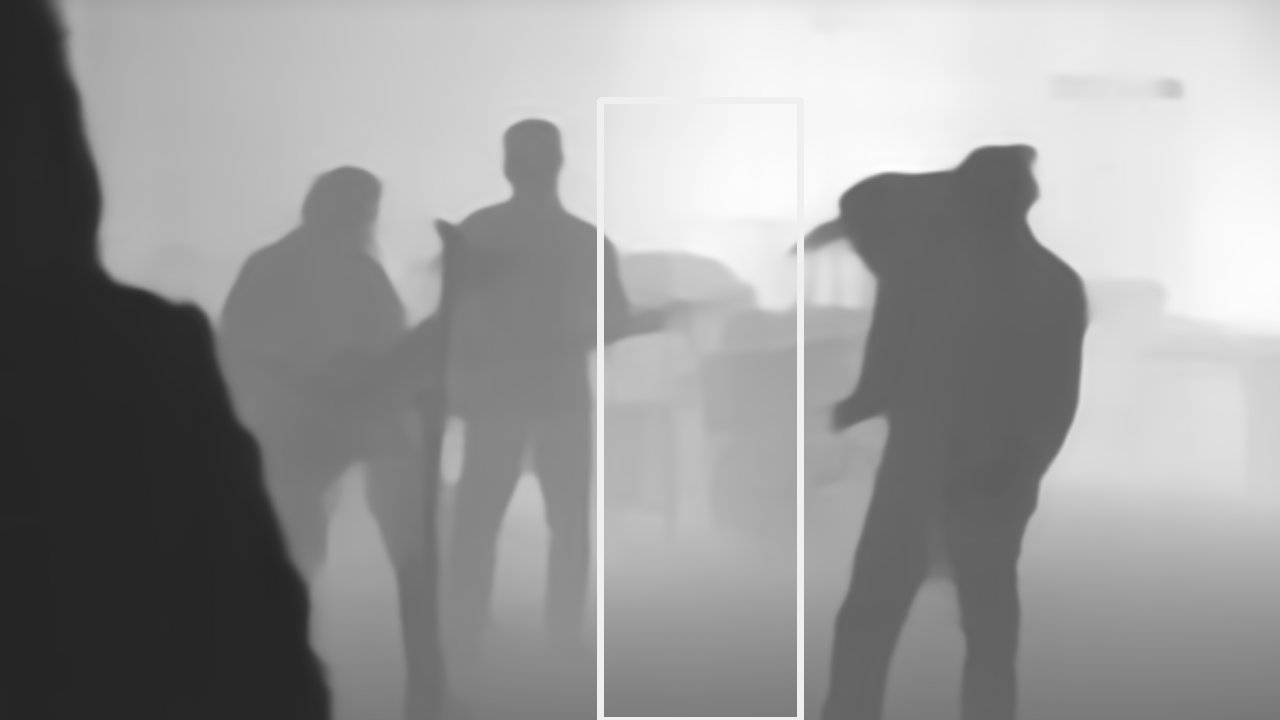

[600, 100, 800, 1300]
956.5539677419355


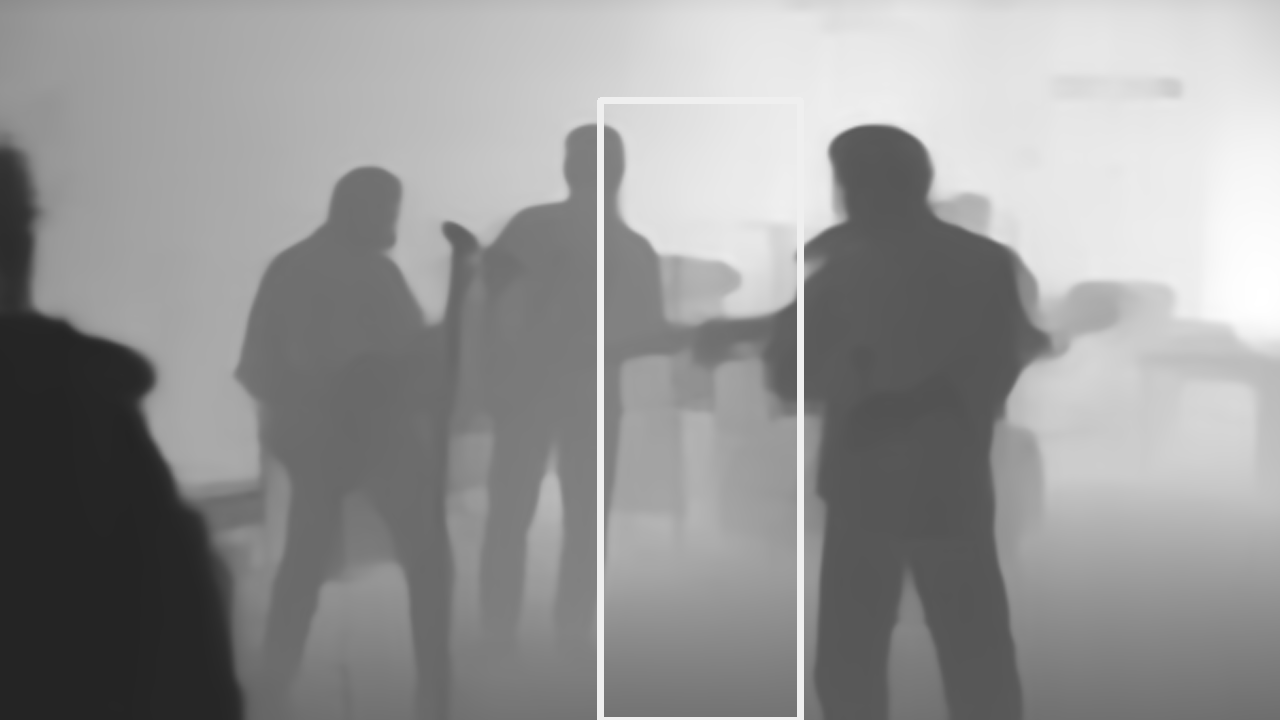

[600, 100, 800, 1300]
910.6034193548387


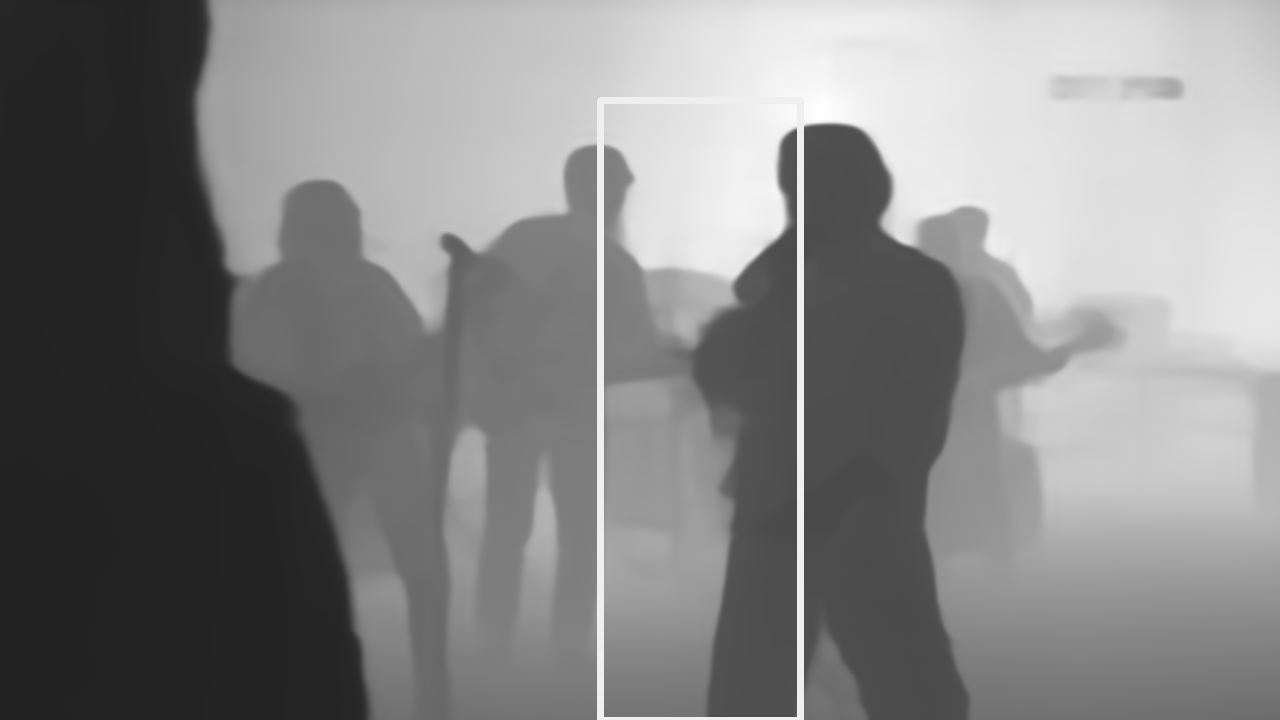

[600, 100, 800, 1300]
807.4398225806451


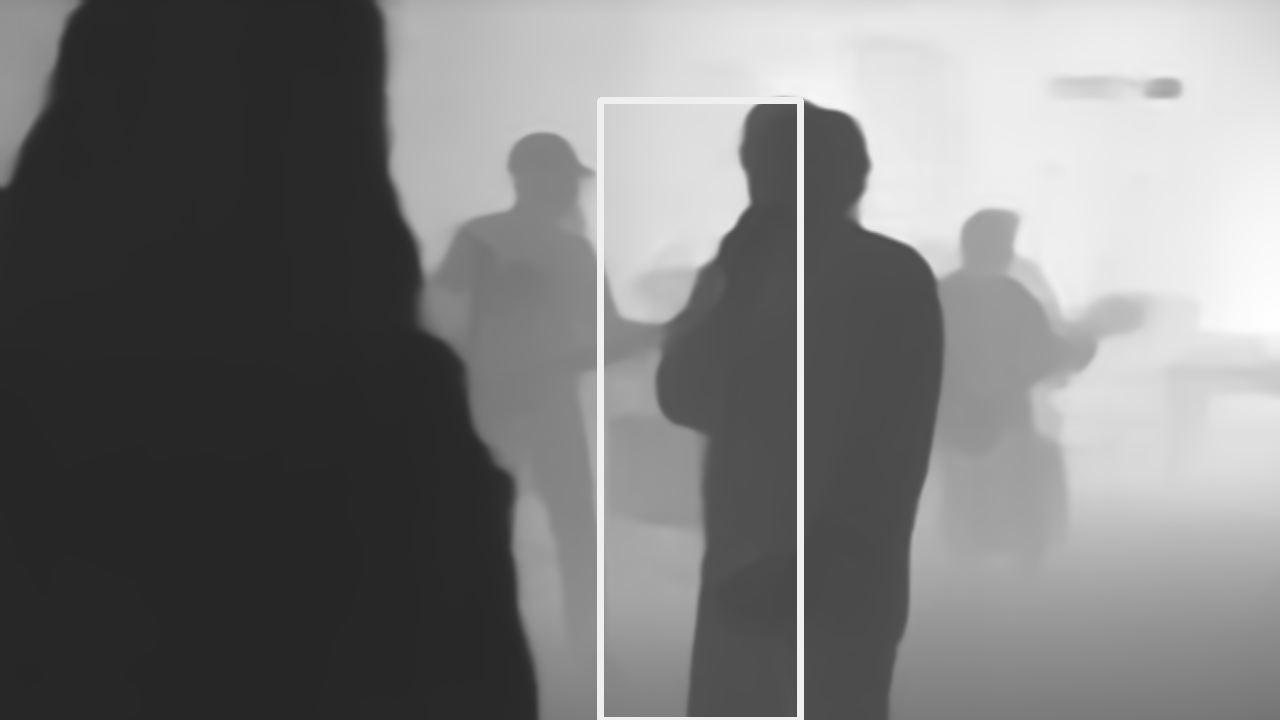

[600, 100, 800, 1300]
696.5310967741935


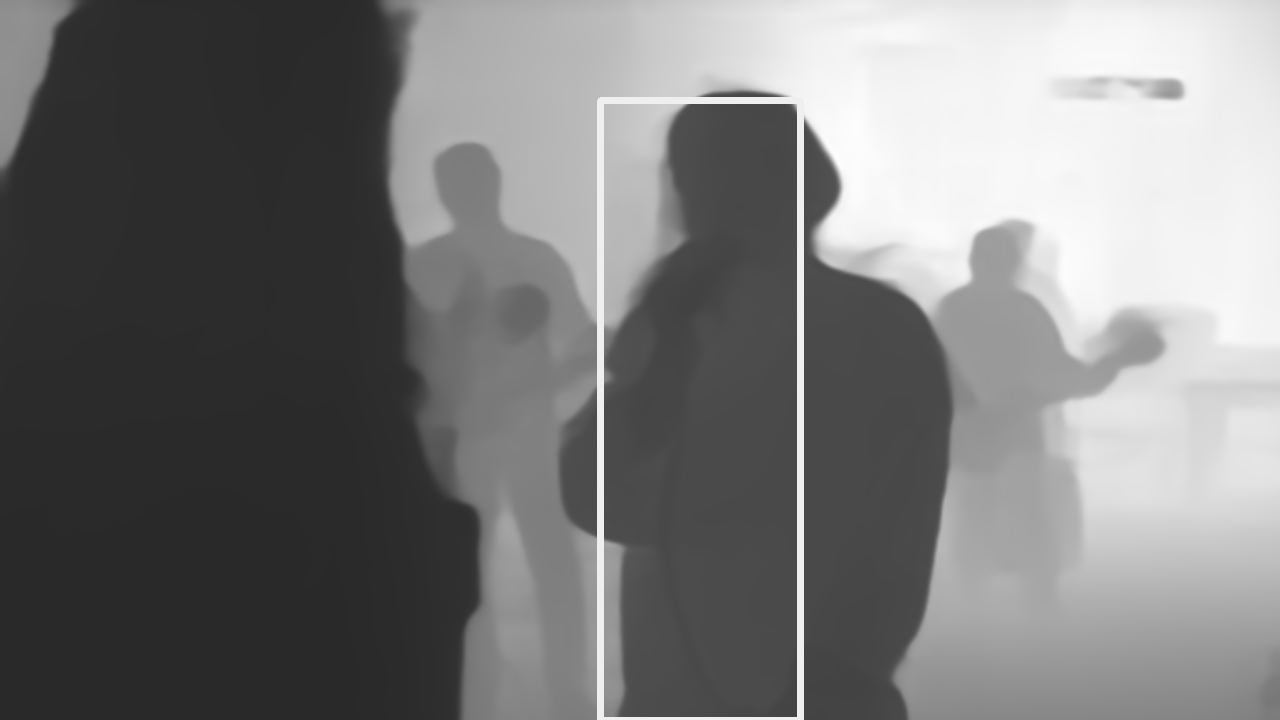

[600, 100, 800, 1300]
450.4983387096774


In [127]:
from PIL import Image 
bbox = [600, 100, 800, 1300]

def clip_bbox(bbox, width, height):
    x, y, x2, y2 = bbox
    x = min(x, width)
    x = max(x, 0)
    x2 = min(x2, width)
    x2 = max(x2, 0)
    y = min(y, height)
    y = max(y, 0)
    y2 = min(y2, height)
    y2 = max(y2, 0)

    if x > x2:
        x, x2 = x2, x
    if y > y2:
        y, y2 = y2, y
    return [x, y, x2, y2]

def load_depth_with_image_id(img_id, bbox=[100,100,200,400], display_img=False):
    """Returns the depth image as numpy array.
    """
    depth_dir_path = '/compute/trinity-2-25/tkhurana/datasets/data/data/tkhurana/TAO-depth/zoe/frames/'
    img = img_id_to_img[img_id]
    depth_img_path = os.path.join(depth_dir_path, img['file_name'].replace('.jpg', '.png')) if '.jpg' in img['file_name'] else img['file_name'].replace('.jpeg', '.png')
    pil_img = Image.open(depth_img_path)

    np_img = np.array(pil_img)
    depth_img = np_img
    
    if display_img:
        np_img = (np_img / np_img.max() * 255)
        np_img = np_img.astype(np.uint8)
        
        bbox = clip_bbox(bbox, np_img.shape[1], np_img.shape[0])
        np_img = cv2.rectangle(np_img, bbox[:2], bbox[2:], (239, 118, 122), 5) 
        display(Image.fromarray(np_img))

    return depth_img

def get_depth_bounding_box(bbox, depth_img):
    """
    Args:
        bbox: [x, y, x2, y2]
        depth_img: np array of shape (width, height)
    Return:
        depth(float): the average of depth inside the bounding box
    """
    # Clip the bbox based on width and height
    height, width = depth_img.shape

    x, y, x2, y2 = list(map(int, clip_bbox(bbox, width, height)))

    if x >= x2 or y >= y2:
        # Completely out-of-frame
        return -1
    
    return depth_img[y:y2, x:x2].mean()


image_ids = vid_to_sorted_img_ids[1344]
import random
for img_id in image_ids[:5]:
    depth_img = load_depth_with_image_id(img_id, bbox, display_img=True)
    depth = get_depth_bounding_box(bbox, depth_img)
    print(bbox)
    print(depth)




## Run Kalman Filter for Each Track 

In [128]:

def preprocess_track(predictions: list):
  """
  Args:
    predictions (List): a list of predictions containing all predictions of this track
  
  Output:
    start_frame (int)
      the image id of the starting frame of this track
    end_frame (int)
      the image id of the ending frame of this track
    box (dict), containing the following key
      image_id
    
    all_frames (list): 
      a sorted list that contains all the image ids in this video

    
  """
  start_frame = float('inf')
  end_frame = float('-inf')
  box = dict()
  for pred in predictions:
    start_frame = min(pred['image_id'], start_frame)
    end_frame = max(pred['image_id'], end_frame)
    box[pred['image_id']] = convert_wh_to_xy(pred['bbox'])
  
  return start_frame, end_frame, box, vid_to_sorted_img_ids[pred['video_id']]
    



  
window_size = 3
min_hit = 3
depend_on_kalman = False  # If True, we modify the original detection results based on the output of kalman filter.

kalman_filtered_prediction = []
img_id_to_depth_img = dict()
for vid in tqdm(vid_trackid_to_predictions):
# for vid in [1344]:
  for track_id, track_predictions in vid_trackid_to_predictions[vid].items():
    start_frame, end_frame, box, all_frames = preprocess_track(track_predictions)

    # Get the average depth in the first frame
    start_depth_img = load_depth_with_image_id(start_frame)
    img_id_to_depth_img[start_frame] = start_depth_img
    start_depth = get_depth_bounding_box(box[start_frame], start_depth_img)

    # Initialize tracker
    tracker = KalmanDepthBoxTracker(box[start_frame] + [start_depth])

    start_idx = all_frames.index(start_frame) 
    end_idx = all_frames.index(end_frame)
    if start_idx == -1 or end_idx == -1 or end_idx < start_idx:
      raise ValueError("Can't find start frame {} and end frame {} of a track {}".format(start_frame, end_frame, track_predictions))
    
    # Update end_idx to end_idx + window_size
    end_idx = min(end_idx + window_size, len(all_frames) - 1)
    last_appear_frame_idx = start_idx

    # Put prediction of the start frame into the list
    kalman_filtered_prediction.append(
        {
            'image_id': start_frame,
            'category_id': track_predictions[0]['category_id'], 
            'bbox': convert_xy_to_wh(box[start_frame]), 
            'score': track_predictions[0]['score'], 
            'track_id': track_id,
            'video_id': vid,
        })

    for frame_idx in range(start_idx + 1, end_idx + 1):
      frame = all_frames[frame_idx]
      if frame not in img_id_to_depth_img:
        img_id_to_depth_img[frame] = load_depth_with_image_id(frame)
      depth_img = img_id_to_depth_img[frame]

      if frame in box:
        observed_box = box[frame].copy()
        if depend_on_kalman and (last_appear_frame_idx + window_size >= frame_idx) and tracker.age >= 3:
          # Modify the original detection box based on the prediction of kalman
          predicted_box = tracker.predict()
          box[frame] = predicted_box[0][:4].tolist()
        tracker.update(observed_box + [get_depth_bounding_box(observed_box, depth_img)])
        last_appear_frame_idx = frame_idx

      elif last_appear_frame_idx + window_size >= frame_idx and tracker.hits >= min_hit:
        predicted_box = tracker.predict()
        depth = get_depth_bounding_box(predicted_box[0][:4].tolist(), depth_img)
        kalman_depth_prediction = predicted_box[0][4]
        if depth < kalman_depth_prediction and depth != -1:
          # Only Hallucinate when the object is occluded
          box[frame] = predicted_box[0][:4].tolist()

      if frame in box:
        kalman_filtered_prediction.append(
        {
            'image_id': frame,
            'category_id': track_predictions[0]['category_id'], 
            'bbox': convert_xy_to_wh(box[frame]), 
            'score': track_predictions[0]['score'], 
            'track_id': track_id,
            'video_id': vid,
        })


100%|██████████| 993/993 [2:44:41<00:00,  9.95s/it]  


## Test on a Single Video 1344 (val/AVA/keUOiCcHtoQ_scene_23_102872-103750)

In [129]:
print("Output kalman filtered results to {}".format(prediction_file.replace('.json', "_kalman_depth.json")))
with open(prediction_file.replace('.json', "_kalman_depth.json"), 'w') as f:
    json.dump(kalman_filtered_prediction, f)

Output kalman filtered results to /data3/chengyeh/TAO-Amodal-experiments/GTR/AmodalExpander/TAO-Amodal/ModalMatch/PasteNOcclude/GTR_TAO_Amodal_Expander_PasteNOcclude/iter45000/inference_tao_amodal_val_v1/lvis_instances_results_kalman_depth.json


In [ ]:
video_id = vname_to_vid['val/AVA/keUOiCcHtoQ_scene_23_102872-103750']
single_video_prediction = [pred for pred in prediction if pred['video_id'] == video_id]
kalman_filtered_single_video_prediction = [pred for pred in kalman_filtered_prediction if pred['video_id'] == video_id]

with open(prediction_file.replace('.json', "_{}.json".format(video_id)), 'w') as f:
    json.dump(single_video_prediction, f)

with open(prediction_file.replace('.json', "_kalman_depth_{}.json".format(video_id)), 'w') as f:
    json.dump(kalman_filtered_single_video_prediction, f)
